In [33]:
import numpy as np
import networkx as nx
from collections import deque
import matplotlib.pyplot as plt

In [28]:
class GraphGenerator:
    def __init__(self, size, rank=0, comm=None):
        self.size = size
        self.rank = rank
        self.comm = comm

    def selectGraph(self, graph, p=None, num_c=None):
        if isinstance(graph, list):
            return graph
        else:
            g = []
            if graph == 'fully-connected':
                fc_graph = nx.complete_graph(self.size)
                g = list(fc_graph.edges)

            elif graph == 'ring':
                ring_graph = nx.cycle_graph(self.size)
                g = list(ring_graph.edges)
            
            elif graph == 'linear':
                for i in range(self.size - 1):
                    g.append((i, i + 1))

            elif graph == 'clique-ring':
                per_c = int(self.size / num_c)
                rem = self.size % num_c
                for i in range(num_c):
                    if i != num_c - 1:
                        fc_graph = nx.complete_graph(per_c)
                        fc_graph = nx.convert_node_labels_to_integers(fc_graph, i * per_c)
                        g += list(fc_graph.edges)
                        g.append((i * per_c + per_c - 1, i * per_c + per_c))
                    else:
                        fc_graph = nx.complete_graph(per_c + rem)
                        fc_graph = nx.convert_node_labels_to_integers(fc_graph, i * per_c)
                        g += list(fc_graph.edges)
                        if num_c > 2:
                            g.append((self.size - 1, 0))

            elif graph == 'erdos-renyi':
                if self.rank == 0:
                    while True:
                        erdos_graph = nx.erdos_renyi_graph(self.size, p)
                        if nx.is_connected(erdos_graph):
                            g = list(erdos_graph.edges)
                            num_edges = len(g) * np.ones(1, dtype=np.int)
                            print('Generated Erdos-Renyi Graph Edges:')
                            print(g)
                            break
                else:
                    num_edges = np.zeros(1, dtype=np.int)
                self.comm.Bcast(num_edges, root=0)
                num_edges = num_edges[0]
                if self.rank != 0:
                    data = np.empty((num_edges, 2), dtype=np.int)
                else:
                    data = np.array(g, dtype=np.int)
                self.comm.Bcast(data, root=0)
                if self.rank != 0:
                    for i in range(num_edges):
                        g.append((data[i][0], data[i][1]))
            return g

In [29]:
def calculate_distances(g, start_node=0):
    # 将边列表转换为无向图
    G = nx.Graph()
    G.add_edges_from(g)
    
    # 初始化距离字典，所有距离为无穷大
    distances = {node: float('inf') for node in G.nodes}
    distances[start_node] = 0
    
    # 使用广度优先搜索计算距离
    queue = deque([start_node])
    
    while queue:
        current_node = queue.popleft()
        current_distance = distances[current_node]
        
        for neighbor in G.neighbors(current_node):
            if distances[neighbor] == float('inf'):  # 如果尚未访问该节点
                distances[neighbor] = current_distance + 1
                queue.append(neighbor)
    max_distance = max(distances.values())
    if max_distance == 0:
        return distances
    distances = {node: distance / max_distance for node, distance in distances.items()}
    
    return distances

In [36]:
generator = GraphGenerator(size=8)
g = generator.selectGraph('ring')
distances = calculate_distances(g)

print(distances)


{0: 0.0, 1: 0.25, 7: 0.25, 2: 0.5, 3: 0.75, 4: 1.0, 5: 0.75, 6: 0.5}


In [25]:
g = generator.selectGraph('fully-connected')
distances = calculate_distances(g)

print(distances)

{0: 0.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [30]:
g = generator.selectGraph('linear')
distances = calculate_distances(g)

print(distances)

{0: 0.0, 1: 0.14285714285714285, 2: 0.2857142857142857, 3: 0.42857142857142855, 4: 0.5714285714285714, 5: 0.7142857142857143, 6: 0.8571428571428571, 7: 1.0}


In [37]:
def visualize_graph(g):
    G = nx.Graph()
    G.add_edges_from(g)
    
    pos = nx.spring_layout(G)  # 用spring布局生成节点位置
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=15)
    plt.title("Graph Visualization")
    plt.show()

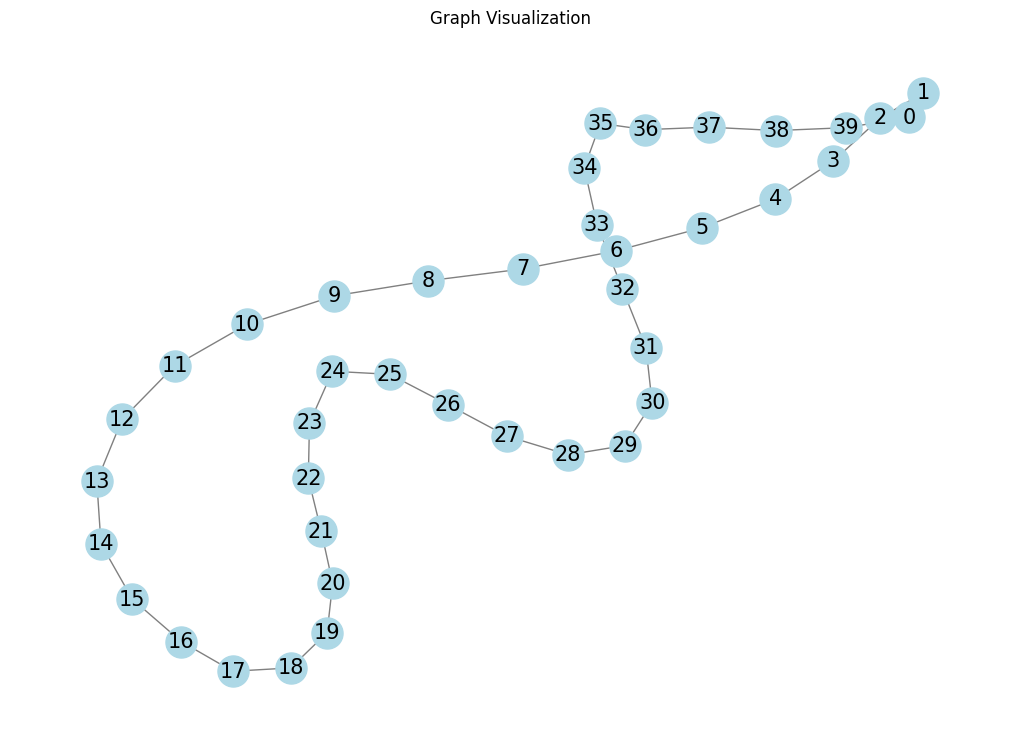

In [41]:
generator = GraphGenerator(size=40)
g = generator.selectGraph('ring')
visualize_graph(g)

In [39]:
generator = GraphGenerator(size=40)
g = generator.selectGraph('clique-ring', num_c=4)

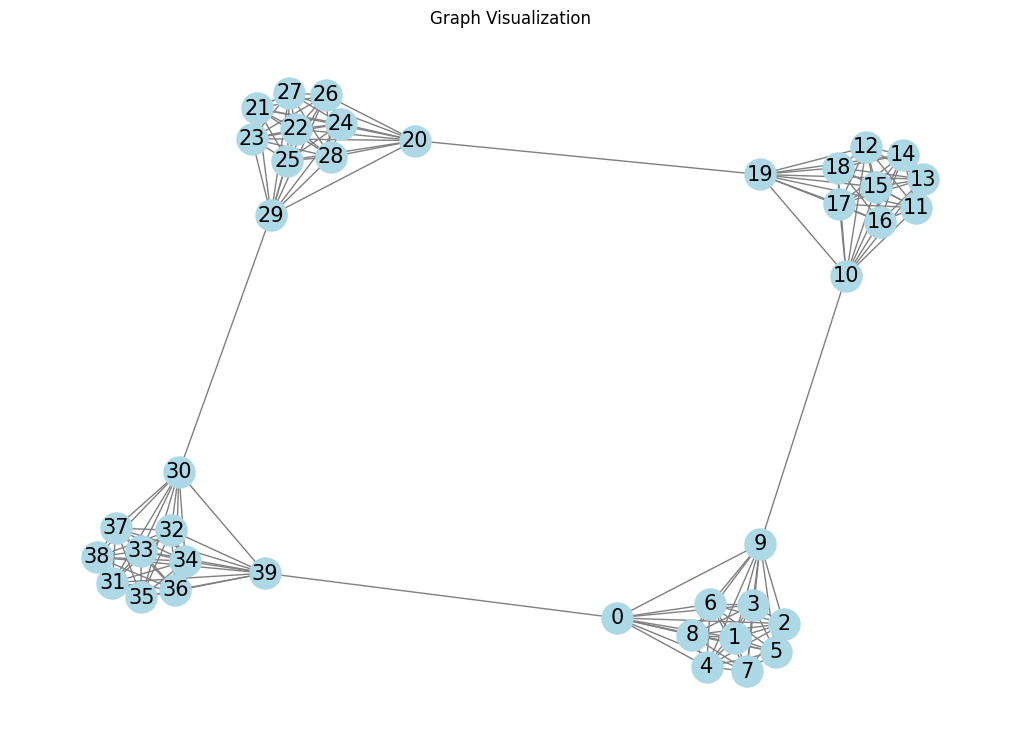

In [40]:
visualize_graph(g)